The following shows how to use the `Embedding` and `DataLoader` classes to obtain information and plot data products given a source id

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
import numpy as np
from astropy.timeseries import LombScargle
from matplotlib import pyplot as plt
sys.path.append('../src')

from data_loader import DataLoader
from embedding import Embedding

dataset_dir = Path('../data')
loader = DataLoader(
    dataset_dir, 
    metadata_path=dataset_dir / 'meta.parquet'
)
emb = Embedding(
    latent_dir=dataset_dir / 'latent_space' / '2', 
    metadata_path=dataset_dir / 'meta.parquet'
)

In [2]:
example_sid = 5519513809845260800

Getting metadata and embedding coordinates

In [3]:
emb.get_all_metadata(example_sid)

{'sourceid': 5519513809845260800,
 'embedding_0': 1.2441823482513428,
 'embedding_1': -0.9196670055389404,
 'macro_class': 'UNKNOWN',
 'class': 'UNKNOWN',
 'L': 262.0572781581258,
 'B': -8.043707012710389}

Plotting the light curve of this source using `get_lightcurve`. This function returns a dictionary with the `g` time series as a $3\times N$ `np.ndarray`

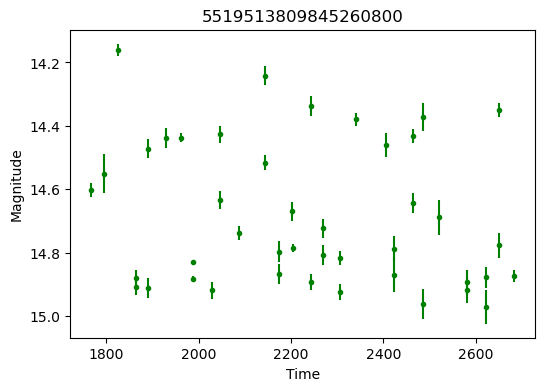

In [4]:
lc = loader.get_lightcurve(example_sid)

time, mag, err = lc['g']

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(time, mag, err, c='g', fmt='.')
ax.invert_yaxis()
ax.set_xlabel('Time')
ax.set_ylabel('Magnitude')
ax.set_title(example_sid);

Obtaining the pre-calculated dominant frequency and plotting the folded light curve.

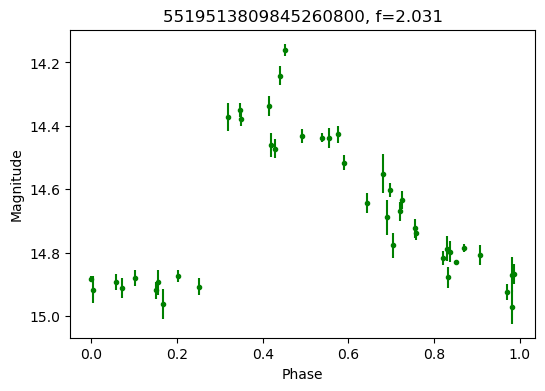

In [5]:
best_freq = loader.get_frequency(example_sid)
phase = np.mod(time,1/best_freq)*best_freq

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(phase, mag ,err, c='g', fmt='.')
ax.invert_yaxis()
ax.set_xlabel('Phase')
ax.set_ylabel('Magnitude')
ax.set_title(f'{example_sid}, f={best_freq:0.3f}');

Extracting dominant frequency manually using astropy's `LombScargle`

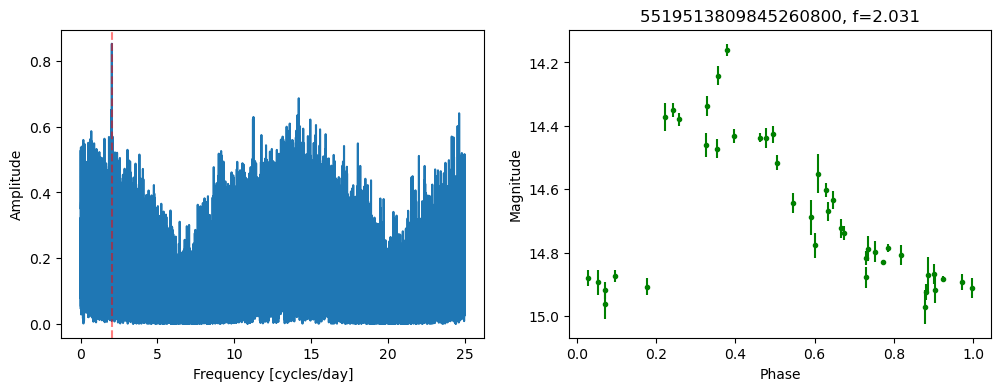

In [6]:
freq = np.arange(1e-3, 25, 1e-4)
ampl = LombScargle(time, mag, err).power(freq, method='fast', assume_regular_frequency=True)
best_freq = freq[np.argmax(ampl)]
phase = np.mod(time,1/best_freq)*best_freq

fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(freq, ampl)
ax[0].axvline(best_freq, c='r', ls='--', alpha=0.5)
ax[0].set_xlabel('Frequency [cycles/day]')
ax[0].set_ylabel('Amplitude')
ax[1].errorbar(phase, mag ,err, c='g', fmt='.')
ax[1].invert_yaxis()
ax[1].set_xlabel('Phase')
ax[1].set_ylabel('Magnitude')
ax[1].set_title(f'{example_sid}, f={best_freq:0.3f}');

Plotting the xp coefficients using `get_continuous_spectra`. This function returns a dictionary with the `bp` and `rp` coefficients and errors

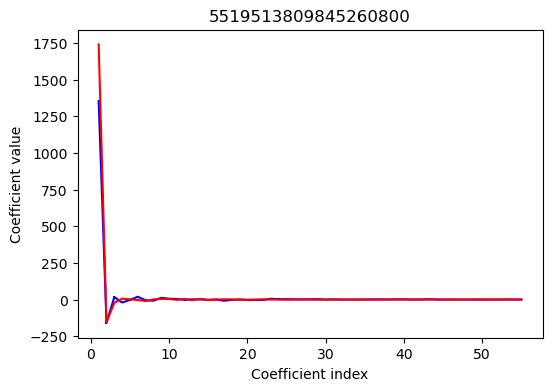

In [7]:
xp = loader.get_continuous_spectra(example_sid)

bp_coef, bp_err = xp['bp']
rp_coef, rp_err = xp['rp']
coef_index = np.arange(1, len(bp_coef)+1, 1)

fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(coef_index, bp_coef, bp_err, c='b')
ax.errorbar(coef_index, rp_coef, rp_err, c='r')
ax.set_xlabel('Coefficient index')
ax.set_ylabel('Coefficient value')
ax.set_title(example_sid);

Plotting sampled xp spectra with `get_sampled_spectra`. This function returns a dictionary with the `bp` and `rp` sampled spectra. This are computed in the fly from the xp coefficients using `gaiaxpy.convert`

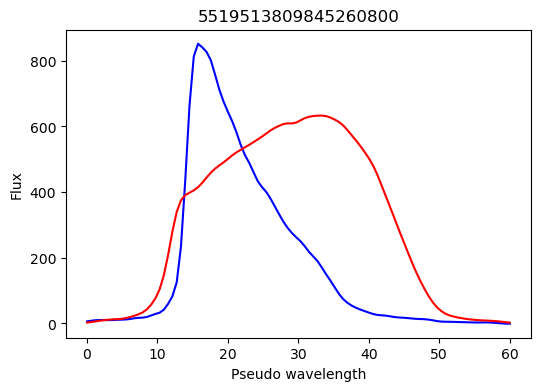

In [8]:
pseudo_wavelenghts = np.linspace(0, 60, 100)
xp = loader.get_sampled_spectra(example_sid, pseudo_wavelenghts=pseudo_wavelenghts)
bp_val, rp_val = xp['bp'], xp['rp']

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(pseudo_wavelenghts, bp_val, c='b')
ax.plot(pseudo_wavelenghts, rp_val, c='r')
ax.set_xlabel('Pseudo wavelength')
ax.set_ylabel('Flux')
ax.set_title(example_sid);